# <font size="10"> Group 27 Project Report </font> 

**Team Members** Khushi Narang, Mengen Liu, Rosha Mehrad, Yilin Long   

# Libraries
**Import necessary packages**

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
install.packages("GGally")
library(GGally)
library(rsample)
install.packages("themis")
library(themis)
install.packages("ggcorrplot")
library(ggcorrplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Introduction

Neutron stars called pulsars are a rare occurrence that occasionally produces audible radio transmissions on Earth. Due to their ability to provide light on space-time, the interstellar medium, and states of matter, these stars have great value for scientific inquiry (see [2] for more uses).

<img src='https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif' width='400'>

 **Figure 1:** A GIF representing a pulsar star. 
 
 Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif

Although each pulsar releases a distinctive pattern of radio signals that differs with each spin, during observation, prospective signals, or "candidates," are averaged over several rotations. Each contender may represent a genuine pulsar in the absence of more information. It is difficult to distinguish between real signals (pulsars) and false positives (noise), as the great majority of detections are brought on by noise and radio frequency interference (RFI).

In this case study, we seek to find an answer to "Can pulsar radio emissions be accurately distinguished from radio frequency interference (RFI) and radio noise?" The dataset that will be used is HTRU2, a set of data that lists a selection of pulsar candidates discovered as part of the High Time Resolution Universe Survey (South). It includes both fake and authentic samples of pulsars.

To do this, we must examine the signals' statistical and observational data (we refer to them as candidates in many places).

The data set's columns are represented in the graphic below.

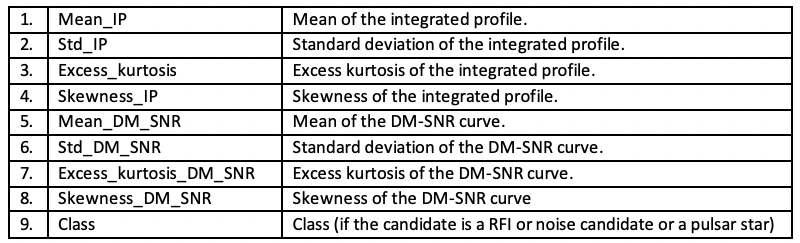

**Figure 2:** An image of a table demonstrating what each variable stands for.

### Restating the question we would like to answer:
 **<font size="3"> Can pulsar radio emissions be accurately differentiated from radio frequency interference (RFI) and radio noise? </font>**

 This is a classification problem where the response variable is evidently "Class". We plan on using the KNN model for our predictions. The methods and results for which are discussed below in detail.

# Methods & Results
### Loading data from the original source on the web 

In order to better comprehend the data we are working with, our first step is to import the data set we want to work with. The `tidyverse` package that we'll need for our analysis was loaded above.

In [2]:
# read the dataset
# Downloaded the zipped Pulsar data from URL
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it
pulsar_data <- read_csv(unz(tf, "HTRU_2.csv"), col_names=FALSE)
head(pulsar_data)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2023-04-17 05:39
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/Rtmpn8eMxN/file1c722fae28ce.zipNULL

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


**Table 1**: This table here represents the first 6 rows of our data from the dataset HTRU2 without assigned column names, a data frame with raw data imported from URL.


### Cleaning and wrangling the data into a tidy format

We observed that column names were not present in the dataset. Therefore, we first wrangled the data by adding the columns names. We did this by using the `rename` function. Also, the class column used 0 to represent RFI noise and 1 to represent pulsar. We also mutated the target class to be more meaningful value for a human.

In [3]:
# add column names using rename
pulsar_data <- rename(pulsar_data, Mean_IP=X1,Std_IP=X2, Excess_kurtosis_IP=X3, Skewness_IP=X4,
                     Mean_DM_SNR=X5, Std_DM_SNR=X6, Excess_kurtosis_DM_SNR=X7, Skewness_DM_SNR=X8, Class=X9)|>

# mutate the class to a more meaningful value for a human instead of 0 and 1
               mutate(Class = as_factor(case_when(Class == 1 ~ "pulsar",
                                                TRUE ~ "rfi_noise")))

head(pulsar_data)

Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rfi_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rfi_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rfi_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,rfi_noise


**Table 2**: Preview of the pulsar data after `Class` has been converted from numeric `1,0` to factor `plusar, rfi_noise`.



**What we observed:** The dataset appears to contain observations of astronomical phenomena, with several features related to the integrated profile (IP) and the DM-SNR curve. The IP features include the mean and standard deviation and measures of excess kurtosis and skewness. Similarly, the DM-SNR curve features include the mean and standard deviation and measures of excess kurtosis and skewness.

### Splitting into training and testing data
It is imprtant to split the data before proceeding any further. This is because including your testing data in data analysis may influence our predictor/k value selection. For this data set, we decided to perform a split of 80/20 train/test for our KNN model.

In [4]:
set.seed(2) # set the random seed
pulsar_split <- initial_split(pulsar_data, prop = 0.8, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

head(pulsar_test)
head(pulsar_train)

Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,rfi_noise
130.38281,39.84406,-0.15832276,0.3895404,1.220736,14.37894,13.539456,198.23646,rfi_noise
107.25000,52.62708,0.45268802,0.1703474,2.331940,14.48685,9.001004,107.97251,rfi_noise
133.25781,44.05824,-0.08105986,0.1153615,1.632107,12.00781,11.972067,195.54345,rfi_noise


Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,rfi_noise
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,rfi_noise
103.0156,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,rfi_noise
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,rfi_noise
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,rfi_noise
142.0781,45.28807,-0.32032843,0.2839525,5.3762542,29.009897,6.076266,37.83139,rfi_noise


**Table 3**: Top table represents the first 6 rows of the testing subset and the bottom table  represents the first 6 rows of the training subset


The `initial_split()` function from the rsample package is used here to split the data into training and testing sets. The prop argument specifies the proportion of data to assign to the training set (in this case, 80%). The strata argument is used to ensure that both the pulsar and RFI noise classes are represented proportionally in both the training and testing sets.

### Summarizing the training data in a table
Here, we will calculate the number and percentage of samples in each class in the training dataset using the `group_by` and `summarize` functions from the `dplyr` package. The resulting table shows the count and percentage of samples for each class.

In [5]:
num_obs <- nrow(pulsar_train)
pulsar_train |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

Class,count,percentage
<fct>,<int>,<dbl>
rfi_noise,13003,90.815756
pulsar,1315,9.184244


**Table 4**: Table showing the number and percentage of observations in each Class.

### Preprocessing the data: Centering and scaling and Balancing

* **Centering and scaling**: It can be seen from Table 2 that some variables have a different scale compared to others. Any variables with a big scale will have a significantly larger effect than variables with a small scale since the classifier predicts classes by finding observations closest to it. But just because a variable has a large scale doesn’t mean that it is more important for making accurate predictions. Therefore, in the following code, we have scaled and centered our data set using `step_center(all_predictors())` and `step_scale(all_predictors())`. 
* **Balancing**: The pulsar data is tidy, but it suffers from a large class imbalance, as we can see from Table 4. Only about 9% of our dataset is classified as a pulsar. This can be a significant source of error in a final KNN model if it is not addressed in the training data processing. Hence, it is important to upsample our data set to make sure it is balanced across the classes (has roughly equal numbers of observation for each class). Below, we used `step_upsample(Class, over_ratio = 1, skip = FALSE) `to balance the dataset by oversampling the minority class.

Then, we plotted a bar plot to show the effect of upsampling on our data set(Figure 3).

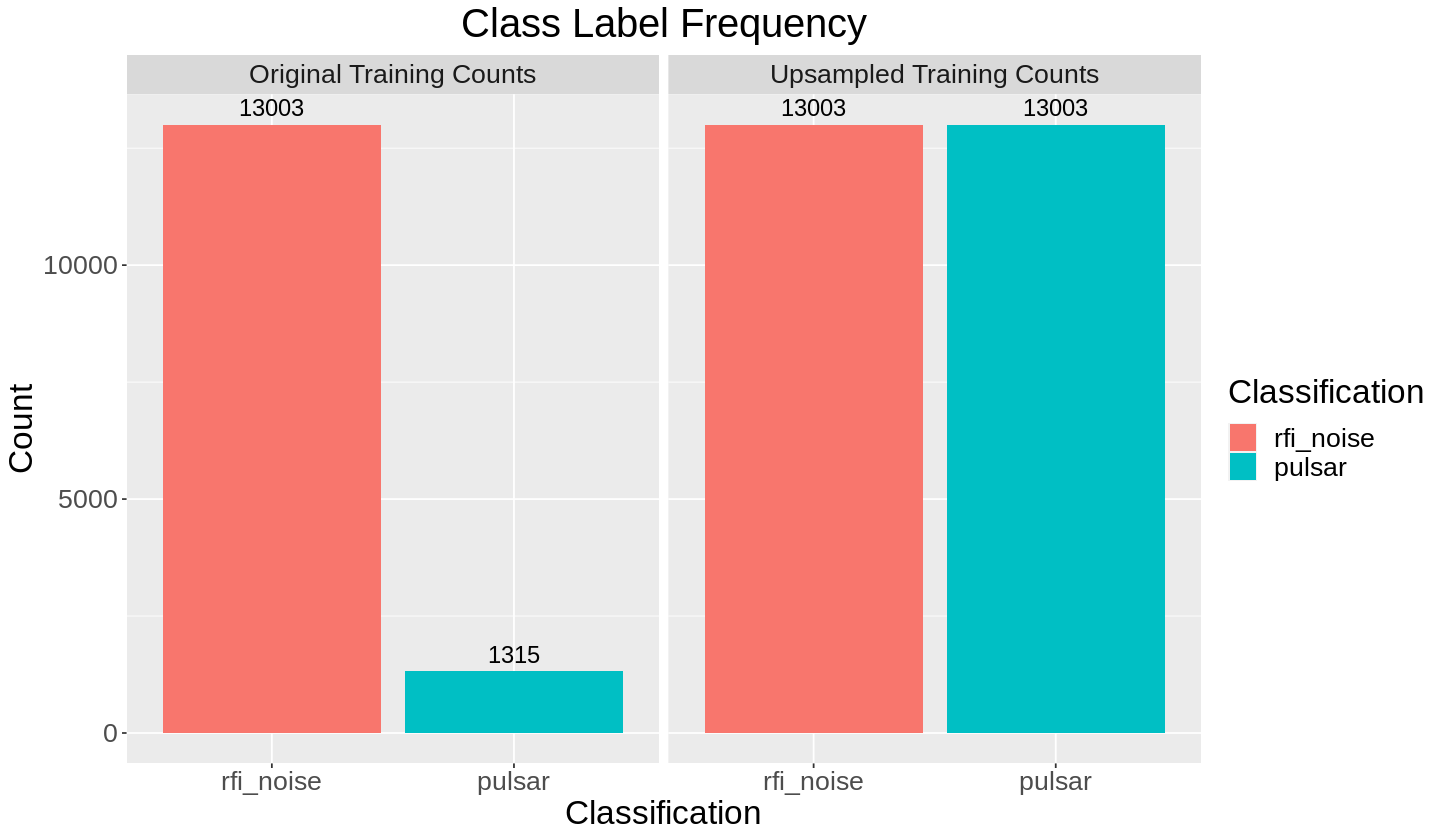

In [6]:
options(repr.plot.width = 12, repr.plot.height = 7)
library(themis)
# create an upsample recipe to account for the class imbalance in the original data set
pulsar_scaled_recipe <- recipe(Class ~ ., data = pulsar_train) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors()) 
  
pulsar_upsample_recipe <- pulsar_scaled_recipe |> 
      step_upsample(Class, over_ratio = 1, skip = FALSE)
  
# prepped training data only scaled
pulsar_train_prepped_scaled <- pulsar_scaled_recipe |> 
                        prep() |>
                        bake(pulsar_train)

# prepped training data scaled and upsampled
pulsar_train_prepped_upsampled <- pulsar_upsample_recipe |> 
                        prep() |>
                        bake(pulsar_train)

# merging the original and upsampled data for side-by-side plotting and comparing purposes
join_by = c("Mean_IP", "Std_IP", "Excess_kurtosis_IP", "Skewness_IP",
                     "Mean_DM_SNR", "Std_DM_SNR", "Excess_kurtosis_DM_SNR", "Skewness_DM_SNR", "Class", "is_prepped")

# created this only for plotting purposes
pulsar_train_prepped_merge <- full_join(pulsar_train |> mutate(is_prepped = FALSE), 
                                    pulsar_train_prepped_upsampled |> mutate(is_prepped = TRUE),
                                     by = join_by)


upsample_compare_bar_plot <- pulsar_train_prepped_merge |> 
                        ggplot(aes(x = Class, fill = Class)) + 
                            geom_bar() +
                            labs(x = "Classification", 
                                 y = "Count",
                                 fill = "Classification") +
                            geom_text(stat='count', aes(label=..count..), vjust = -0.5, size=5) +
                            ggtitle("Class Label Frequency") +
                            theme(text = element_text(size=20),
                                  plot.title = element_text(hjust = 0.5)) +
                            facet_wrap(~ is_prepped,
                                   labeller = labeller(is_prepped = c("TRUE" = "Upsampled Training Counts", 
                                                                      "FALSE" = "Original Training Counts")))
upsample_compare_bar_plot  

**Figure 3**: Effect of Upsampling using original and upsampled training data on the frequency of each class.

Here we can see that the majority of the classes were noises without upsampling. Precisely 13003 non-pulsar and 1315 pulsar. Now, we have a balanced class distribution. 

### Exploratory Data Analysis: Visualizing our data to investigate and figure out the predictors

Before we begin with any modelling, let's investigate our data collection to figure out the variables we will sue for our classifier! First, we need to explore and understand the relationships between variables provided by the HTRU2 dataset. We used data analysis techniques, such as visualization tools, to identify patterns, trends, and coorelation between the variables in the data.

Below, we have used pair plots used to understand the best set of features to explain a relationship between two variables or to form the most separated clusters. This will help us select the predictor variables for our classifier.

**Note:** Here, we used only scaled and centered data and not the upsampled data.

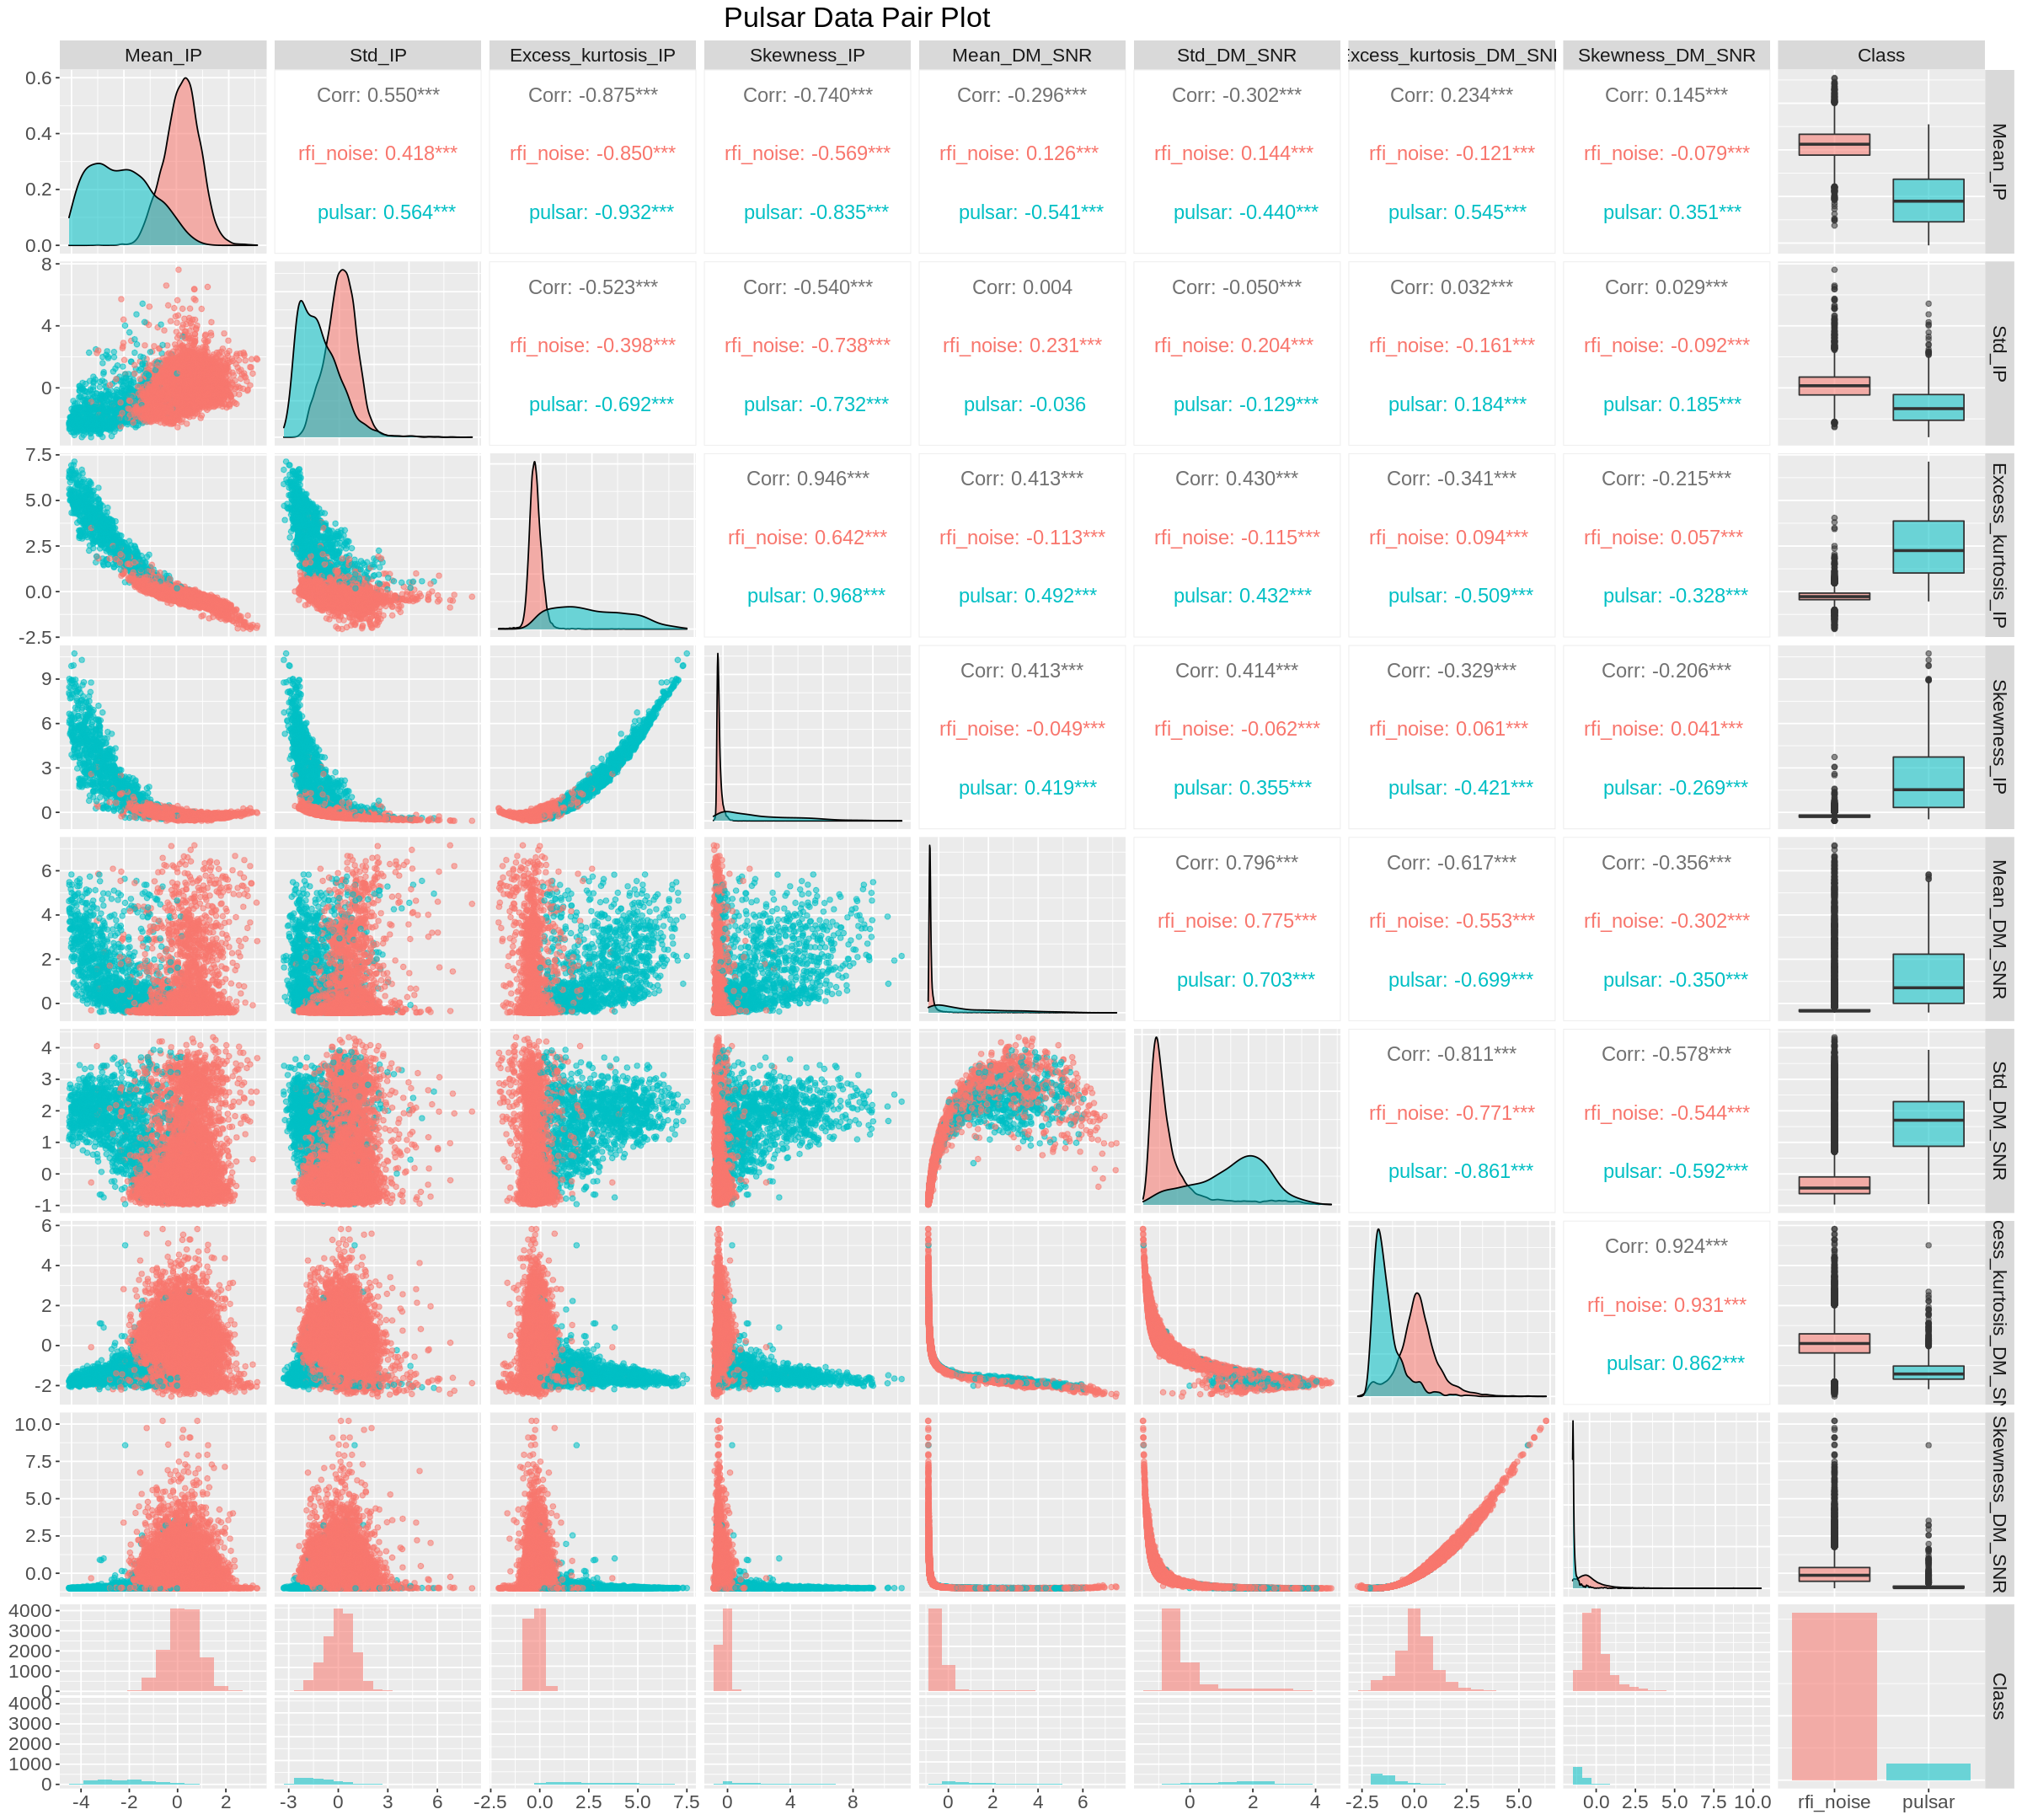

In [7]:
options(repr.plot.width = 20, repr.plot.height = 18)
 
# used the scaled data

ggpairs(pulsar_train_prepped_scaled,
           mapping = aes(color=Class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.6)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Pulsar Data Pair Plot") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.4))

**Figure 4**: A scatter plot with multiple facets, where each plot is a variable is plotted against every other variable, with different plot types drawn depending on the combination of variable types. **This figure takes time to load.**

Looking at the plot above, we can see that there is a significant overlap between pulsars and radio noise in many of the given variables. Hence, we will filter extreme outliers for better training of our classification model. In this case, we can see that `Skewness_DM_SNR`, `Excess_kurtosis_DM_SNR`, and `Std_DM_SNR`do not provide good demarcation of Class when plotted against the other variables.

To further investigate this matter, we will determine the correlation between each of the variables. To do this, we will use the `cor()` function from `ggcorrplot` package (which has already been installed). To calculate the correlation matrix, we need to remove the Class variable from it. Then, use `ggcorrplot()` function for a better visualization of the correlation matrix:

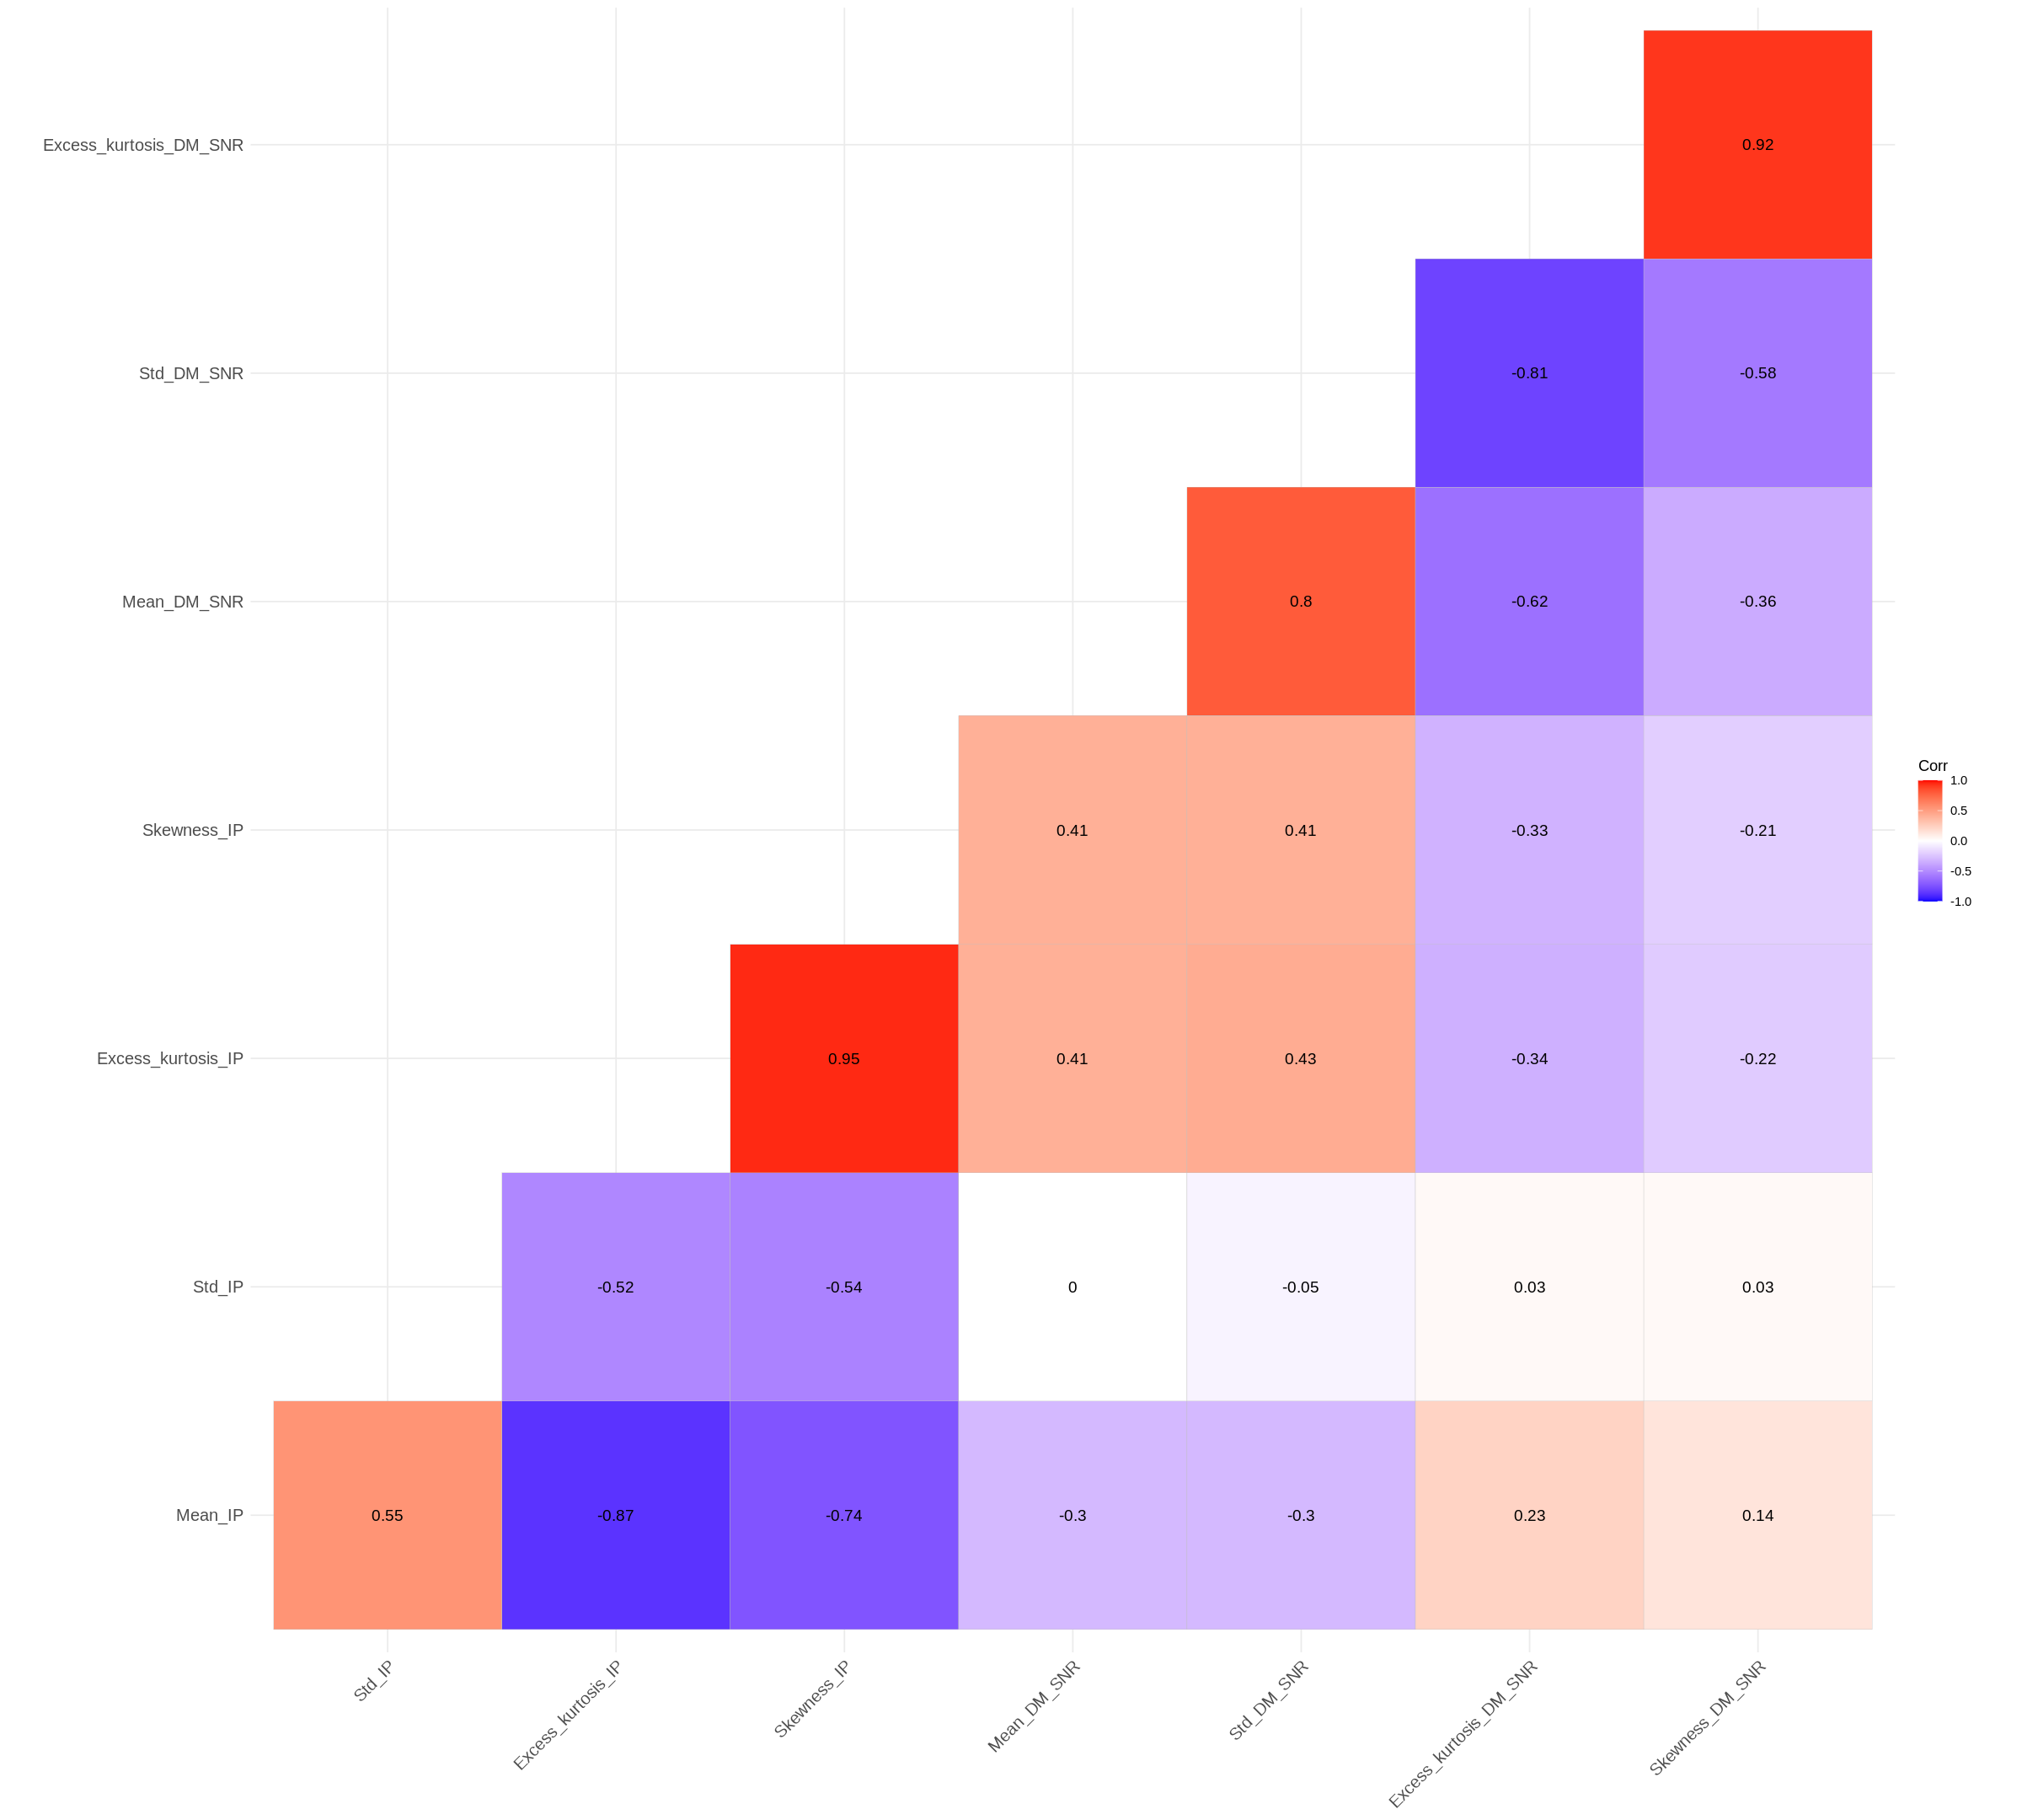

In [8]:
# Calculate correlation matrix
cor_matrix <- cor(select(pulsar_train_prepped_scaled, -Class))

# Visualize correlation matrix
ggcorrplot(cor_matrix, type = "lower", lab = TRUE)

**Figure 5**: A correlation matrix plot with multiple facets where each plot is a variable is plotted against every other variable.

It is evident from Figure 3 that `Mean_IP`, `Excess_kurtosis_IP` and `Mean_DM_SNR` provide fairly high coorelation coefficients against other variables for a range of variables.

Based on our deductions from the pair plots and correlation matrix and our analysis of the data, we decided we will exclude the following variables from our dataset to create the classifier:

* **Std_IP**
* **Skewness_DM_SNR**
* **Excess_kurtosis_DM_SNR**
* **Std_DM_SNR**

Overall, the decision to exclude these variables from the model was based on their low discriminative power, as revealed by the exploratory data analysis.

Now, let's actually remove them from our subsets of data

In [9]:
pulsar_train <- select(pulsar_train, -Std_IP, -Skewness_DM_SNR, -Excess_kurtosis_DM_SNR, -Std_DM_SNR)
head(pulsar_train)

Mean_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,-0.23457141,-0.6996484,3.1998328,rfi_noise
102.5078,0.46531815,-0.5150879,1.6772575,rfi_noise
103.0156,0.32332837,1.0511644,3.1212375,rfi_noise
119.4844,0.03146022,-0.1121676,0.9991639,rfi_noise
107.2578,0.46588196,1.1628771,4.0794314,rfi_noise
142.0781,-0.32032843,0.2839525,5.3762542,rfi_noise


**Table 5**: This table represent the first 6 rows of the original pulsar_train subset after removing the weakest predictors.

### Tuning the model

We perform a 5-fold cross-validation using our chosen predictors `Class ~ Mean_IP + Excess_kurtosis_IP + Skewness_IP + Mean_DM_SNR` in order to determine the optimum $k$ parameter for our nearest neighbor classification. To avoid ties, we evaluate it for the odd values $k = 1,3,5,7,9,11,13,15$ since KNN will use a simple majority to select the class label and we have only two classes.

In the code below, the `workflow()` function is used to specify the pipeline for the recipe and model. The `collect_metrics()` function is used to retrieve the performance metrics.
We filtered the accuracy estimates from the `knn_results` object and assigns them to the `accuracy_estimates` object. 

We also print out the accuracy estimates contianing the `mean` and `std_err`, which is a measure of how uncertain we are in the mean value to examine the accuracy in a better way.
 

In [10]:
set.seed(2)
#kknn specification with euclidean distance
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
# set 5 folds 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5 , strata = Class)

# cross validation to find accuracy of different k neighbors when using specified variables as predictors
optimum_recipe <- recipe(Class ~ Mean_IP + Excess_kurtosis_IP + Skewness_IP +
                                          Mean_DM_SNR, data = pulsar_train) |> 
                        step_center(all_predictors()) |> 
                        step_scale(all_predictors()) |> 
                        step_upsample(Class, over_ratio = 1)

gridvals <- tibble(neighbors = seq(1, 15, by = 2))

knn_results <- workflow() |>
    add_recipe(optimum_recipe) |> 
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = gridvals)  |>
    collect_metrics() 

# filter to the accuracies of each neighbor
accuracy_estimates <- knn_results |>
              filter(.metric %in% c("accuracy")) |>
               select(neighbors, mean, std_err)
accuracy_estimates

neighbors,mean,std_err
<dbl>,<dbl>,<dbl>
1,0.9682919,0.0011533713
3,0.9623552,0.0005970127
5,0.9540441,0.0015506732
7,0.9474788,0.0011958702
9,0.9386787,0.0009253135
11,0.9330214,0.0016013187
13,0.9282721,0.0017160373
15,0.9291104,0.0023692837


**Table 6:** Accuracy estimates for each of the $k$ values.

Looking at the `std_err` column, it is safe to say that in our case, the error won't cause much of a difference in the accuracy.

### Plotting the accuracy vs $k$ graph to pick optimum $k$ parameter
We can decide which number of neighbors is best by plotting the accuracy versus $K$.
The code below generates a plot that helps to visualize the relationship between the number of neighbors and the accuracy of the KNN classification model.
 

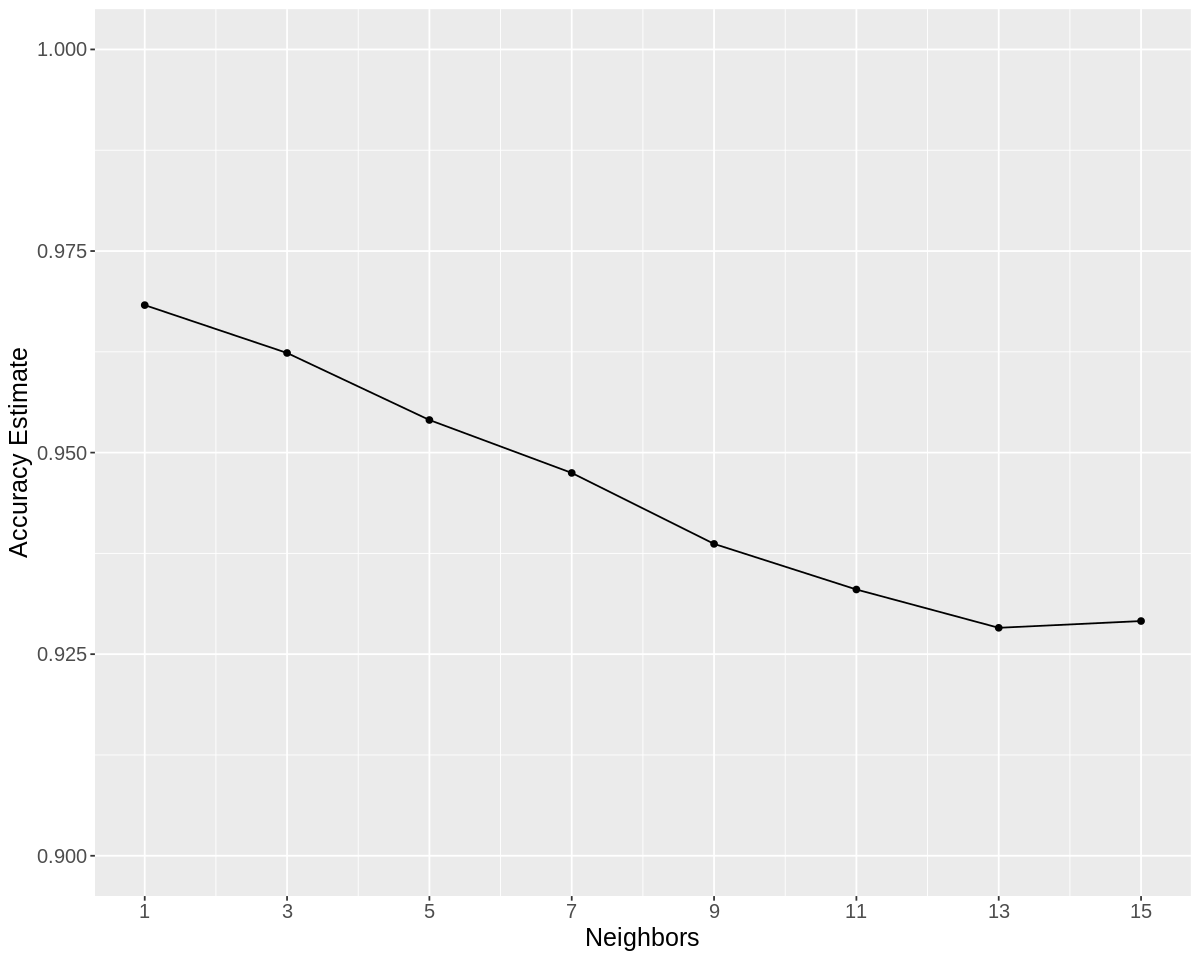

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)

accuracy_vs_k <- ggplot(accuracy_estimates, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  scale_x_continuous(breaks = seq(1, 15, by = 2)) + 
  scale_y_continuous(limits = c(0.9 , 1.0)) +
  theme(text = element_text(size = 15))

accuracy_vs_k

**Figure 6**: A k-neighbours vs accuracy line graph

Based on Figure 6, we select $k=3$ as our optimal $k$, even though it has a little lower accuracy than $k=1$ because $k=1$ would overfit the training data.

Finally, it is time to train our model.

### Training our model

Now, let's set up a new KNN model specification with $k = 3$, which we selected on the basis of Figure 6.

In [12]:
#kknn specification k = 3
new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 3) |>
                set_engine("kknn") |>
                set_mode("classification")

We, then fit the model on the pulsar data using the `workflow()` function.

In [13]:
knn_fit <- workflow() |>
  add_recipe(optimum_recipe) |>
  add_model(new_knn_spec) |>
  fit(data = pulsar_train)
knn_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_center()
• step_scale()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.01461201
Best kernel: rectangular
Best k: 3

### Predicting the labels in the test set
We now have a $K$-nearest neighbors classifier object. We can use it to predict the class labels for our test set. Below, we will do that and use `bind_cols` to add the column of predictions to the original test data. The `Class` variable contains the true classification, while the `.pred_class` contains the predicted classification from the classifier.

In [14]:
pulsar_test_predictions <- predict(knn_fit, pulsar_test) |>
  bind_cols(pulsar_test)

# 5 random predictions
sample_n(pulsar_test_predictions, 5)

.pred_class,Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
rfi_noise,143.1094,43.22818,-0.18533244,0.190629930,1.6513378,13.404861,11.122217,151.96088,rfi_noise
rfi_noise,100.4141,42.25065,0.27828632,0.648750879,2.6755853,21.959870,8.779949,79.28266,rfi_noise
rfi_noise,115.8906,47.91044,0.02333031,0.043420510,0.5518395,9.594966,21.641726,512.04441,rfi_noise
rfi_noise,110.3750,46.88667,0.03434855,0.216369836,1.6262542,13.451509,12.720558,198.07042,rfi_noise
rfi_noise,110.4688,44.96108,0.31618682,-0.008498042,2.2550167,15.406781,8.906188,97.39733,rfi_noise


**Table 7:** A random set of 5 predictions from `pulsar_test_predictions`.

### Analysing the results 


To assess the accuracy of our classifier, we print the statistics about the quality of our model using the `metrics` function.

In [15]:
# Estimate of the truth and our predictive class
pulsar_metrics <- pulsar_test_predictions |>
                 metrics(truth = Class , estimate = .pred_class) |>
                 filter(.metric == "accuracy")
print("Pulsar Model Metrics on Testing Data")
pulsar_metrics

[1] "Pulsar Model Metrics on Testing Data"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9617318


**Table 8:** Model accuracy on the testing data.

Additionally, we have the ability to examine the confusion matrix for the classifier. This matrix displays the predicted labels in comparison to the actual or correct labels.

In [16]:
# Confustion matrix of truth and our predictive class
confusion <- pulsar_test_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)
print("Pulsar Model Confusion Matrix on Testing Data")
confusion

[1] "Pulsar Model Confusion Matrix on Testing Data"


           Truth
Prediction  rfi_noise pulsar
  rfi_noise      3161     42
  pulsar           95    282

**Figure 7**: Confusion matrix which shows the number of true positives, true negatives, false positives, and false negatives.

Our model has an accuracy of $96.17\%$ (from Table 8) on the testing dataset. Also, looking at our confusion matrix, we can say that $282$ times out of $282+95 = 377$, it predicted a pulsar star correctly. This gives us a precision of about $74.8\%$. This seems to be fairly good.

# Discussion

### Summary and Expected Findings:
The classification model allowed us to classify between pulsar and noise based on the statistical measures given in the data set. We had expected to accurately distinguish a pulsar star from radio frequency interference and noise. We believe our findings do meet our expectations.

Using visualization and our scientific reasoning, we concluded that the optimal predictors are `Mean_IP`, `Excess_kurtosis_IP`, `Skewness_IP`, and `Mean_DM_SNR`. Using cross-validation, we got to know our optimal `k` value (accuracy of $96.23\%$. Then, we trained our KNN model to predict `Class` for our testing data. We got an accuracy of $96.17\%$, which we believe is reasonably good given the distribution of our data.

To achieve the above results, we performed an $80/20$ split. We also scaled, centered, and upsampled our training data.

The confusion matrix, pair plot, and correlation matrix proved to be powerful tools to help us analyze the data and thereafter make this classifier.

**Limitations:**
* Although we attained a fairly good accuracy, it is worth considering that the KNN algorithm is a basic algorithm used for classification. There may be other much more complex tools (like SVMs, neural networks, etc.)  to create a higher-accuracy classifier [9].
* Also, given the computational power and time, we could only tune the model using $k$ values up to $15$. Perhaps, using $k$ values till a three-digit number would have yielded better accuracy estimates. Although, the results are indicative of the fact $15$ proved to be a good maximum value to retain the efficiency of our classifier in terms of computational time.


### Impact of findings

Predicting pulsars has significant implications for both astrophysics and technology. Below, we discussed a few.

* **Astrophysics[3]:** Pulsars are dense, rapidly rotating neutron stars that emit beams of radiation. Predicting the locations of pulsars can help astronomers plan observations and study the properties of these objects in more detail.

* **Gravitational waves[4]:** Pulsars are also important for detecting gravitational waves, which are ripples in space-time caused by the motion of massive objects. Knowing the locations of pulsars can help astronomers identify potential sources of gravitational waves and improve their chances of detecting them.

* **Navigation:** Pulsars could also be used for space navigation. They are extremely regular in their emission, so they can be used as a kind of cosmic clock to help spacecraft navigate through the solar system and beyond.

### Future Questions

Based on the results and limitations of our study, more studies should be done about the pulsars. 
Since radio frequency wave emissions can provide important information about pulsars. In the future, we could incorporate a regression model to determine the rotation rate and magnetic field strength of the pulsars. This might arise further questions in the field of science governing the pulsar stars and its impications.


# References

[1] R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

[2] D. R. Lorimer and M. Kramer, "Handbook of Pulsar Astronomy", Cambridge University Press, 2005.

[3] Pulsars, transients and relativistic astrophysics. (2023, April 5) University of Oxford Department of Physics.. Retrieved April 10, 2023

[4] Listening for Gravitational Waves Using Pulsars. (2023). NASA. https://www.nasa.gov/feature/jpl/listening-for-gravitational-waves-using-pulsars

[5] Lyon, R. J., Stappers, B. W., Cooper, S., Brooke, J. M., & Knowles, J. D. (2016). Fifty Years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459(1), 1104–1123. https://doi.org/10.1093/mnras/stw656

[6] PSC search guide.pdf - searching for and identifying pulsars Ryan S. Lynch RLYNCH physics.mcgill.ca department of physics mcgill university 3600: Course hero. PSC search guide.pdf - Searching for and Identifying Pulsars Ryan S. Lynch rlynch physics.mcgill.ca Department of Physics McGill University 3600 | Course Hero. (n.d.). Retrieved April 14, 2023, from https://www.coursehero.com/file/144496696/PSC-search-guidepdf/

[7] Pulsars, transients and relativistic astrophysics. University of Oxford Department of Physics. (2023, April 5). Retrieved April 14, 2023, from https://www.physics.ox.ac.uk/research/group/pulsars-transients-and-relativistic-astrophysics 

[8] Bhandari, A. (2023, April 13). Guide to AUC ROC curve in machine learning : What is specificity? Analytics Vidhya. Retrieved April 14, 2023, from https://www.analytic

[9] Guo, G., Wang, H., Bell, D. A., & Bi, Y. (2004, August 8). KNN Model-Based Approach in Classification. ResearchGate; unknown. https://www.researchgate.net/publication/2948052_KNN_Model-Based_Approach_in_Classification

‌